In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import skew, zscore
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [44]:
data = pd.read_csv('/content/drive/MyDrive/Datasets/mercari-price-suggestion-challenge/mercari-price-suggestion-challenge-train.csv')
data

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


# **FILLING NULL**

In [45]:
data.isnull().sum()

,0
train_id,0
name,0
item_condition_id,0
category_name,6327
brand_name,632682
price,0
shipping,0
item_description,6


***1."Brand name": column này có liên hệ với Name, trong cột Name có thể chứa tên của Brand name, vì vậy, ta sẽ phân tích Name và lọc ra các giá trị này***

In [46]:
# Tạo từ điển điểm số cho các thương hiệu
brand_score = dict(data[data.brand_name.notnull()]["brand_name"].value_counts())

# Hàm để xử lý mỗi hàng
def process_row(row):
    if pd.isnull(row['brand_name']):
        words = row['name'].split()
        score = [brand_score.get(word, -1) for word in words]
        if not words:
            return "missing"
        max_score = max(score)
        if max_score > 0:
            return words[score.index(max_score)]
        else:
            return np.nan
    else:
        return row['brand_name']

# Áp dụng hàm cho từng hàng
data['brand_name'] = data.apply(process_row, axis=1)

In [47]:
# Sử dụng category_name và price để bù các giá trị brand_name bị NaN
def most_frequent_brand(group):
    # Tính value_counts của group, nếu có giá trị thì trả về giá trị phổ biến nhất, nếu không thì trả về NaN
    if group["brand_name"].value_counts().size > 0:
        return group["brand_name"].value_counts().idxmax()
    else:
        return np.nan

# Áp dụng most_frequent_brand theo từng nhóm category_name và price, giữ nguyên chỉ số gốc
most_frequent_brand = data.groupby(["category_name", "price"]).apply(most_frequent_brand).reset_index(level=[0, 1], drop=True)

# Điền các giá trị brand_name bị thiếu dựa trên giá trị phổ biến nhất trong nhóm
data["brand_name"] = data["brand_name"].fillna(most_frequent_brand)

***2.Bổ sung thêm một số column mới:***

In [48]:
def add_columns(data):
  #CATEGORY_NAME
    #Tách cột này thành ba cột 'first_category', 'second_category', và 'third_category' thông qua dấu gạch chéo đã có:
    data[["first_category", "second_category", "third_category"]] = data["category_name"].str.split('/', n=2, expand=True)
  #ITEM_DESCRIPTION
    #Đổi các giá trị 'no description' thành Null
    data["item_description"] = data["item_description"].replace({"no description": np.nan})
    #kiểm tra xem item_description có chứa giá trị liên quan đến giá tiền không
    data["price_in_description"] = data["item_description"].str.contains("\[rm\]")
    #kiểm tra xem cột name có chứa ký hiệu giá tiền hay không.
    data["price_in_name"] = data["name"].str.contains("\[rm\]")
    #đo độ dài mô tả, phân chia các giá trị thành các nhóm (bins)
    data["descr_len"] = data["item_description"].str.len()
    data["descr_len"] = pd.cut(data["descr_len"], np.arange(0, 1055, 5), right=False)
    data["descr_len"] = data["descr_len"].astype("object")

    return data
data = add_columns(data)

In [49]:
#Xóa đi tất cả các dòng Null
data = data.dropna()

***Sau khi đã bổ sung, ta sẽ xóa đi các columns không còn giá trị nữa:***

In [50]:
data = data.drop(columns=['name', 'category_name'])

# **OUTLIERS DROPPING**

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991041 entries, 0 to 1482531
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   train_id              991041 non-null  int64  
 1   item_condition_id     991041 non-null  int64  
 2   brand_name            991041 non-null  object 
 3   price                 991041 non-null  float64
 4   shipping              991041 non-null  int64  
 5   item_description      991041 non-null  object 
 6   first_category        991041 non-null  object 
 7   second_category       991041 non-null  object 
 8   third_category        991041 non-null  object 
 9   price_in_description  991041 non-null  object 
 10  price_in_name         991041 non-null  bool   
 11  descr_len             991041 non-null  object 
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 91.7+ MB


***Tính toán skewness cho một số columns số***

In [52]:
skew_list = ['item_condition_id', 'price', 'shipping']
for i in skew_list:
  skewness = skew(data[i])
  print(f"Skewness của cột {i}:", skewness)

Skewness của cột item_condition_id: 0.26608197852531645
Skewness của cột price: 10.707060040963912
Skewness của cột shipping: 0.3748204179826446


***Như vậy, 'Price' có độ lệch cao, nhưng 'item_condition_id' và 'shipping' thì gần như phân phối chuẩn.***

In [53]:
#Z-score cho phân phối chuẩn:
z_list = ['item_condition_id', 'shipping']
threshold = 3  # Xác định ngưỡng cho outlier

for i in z_list:
  data.loc[:, 'z_score'] = zscore(data[i])   # Tính Z-score cho cột hiện tại
  data = data[(data['z_score'] <= threshold) & (data['z_score'] >= -threshold)]   # Lọc và loại bỏ các giá trị ngoại lệ

# Loại bỏ cột 'z_score' sau khi lọc
data = data.drop(columns=['z_score'])

print("Dữ liệu sau khi loại bỏ các ngoại lệ bằng phương pháp Z-score:")
print(data.shape)

Dữ liệu sau khi loại bỏ các ngoại lệ bằng phương pháp Z-score:
(989142, 12)


In [54]:
#Tính toán IQR cho dữ liệu phân phối không chuẩn
IQR_list = ['price']

for i in IQR_list:
  #tính toán IQR thông qua Q1,
  Q1 = data[i].quantile(0.25)
  Q3 = data[i].quantile(0.75)
  IQR = Q3 - Q1

  # Xác định ngưỡng cho giá trị ngoại lệ
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Nếu bạn muốn loại bỏ các giá trị ngoại lệ
  data = data[(data[i] >= lower_bound) & (data[i] <= upper_bound)]

print("Dữ liệu sau khi loại bỏ Outliers sử dụng IQR:")
print(data.shape)

Dữ liệu sau khi loại bỏ Outliers sử dụng IQR:
(907377, 12)


# **EDA**

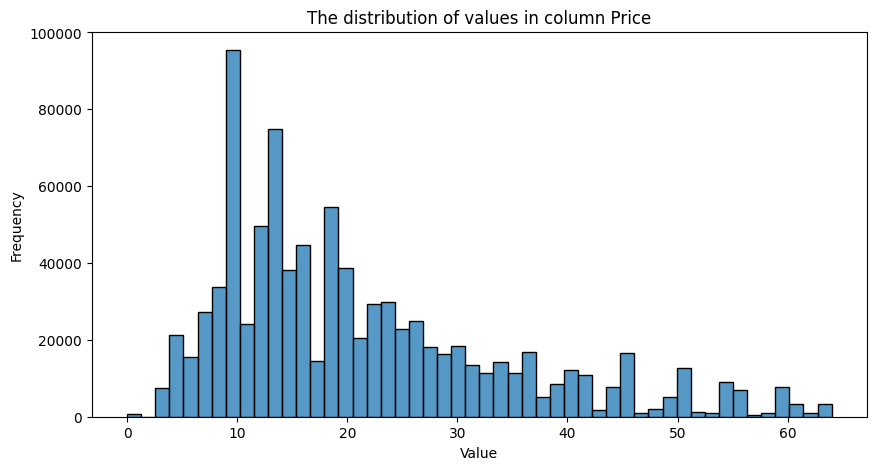

In [55]:
#Vẽ biểu đồ phân phối cho thu nhập:
plt.figure(figsize=(10, 5))
sns.histplot(data['price'], bins=50, edgecolor='black')
plt.title('The distribution of values in column Price')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

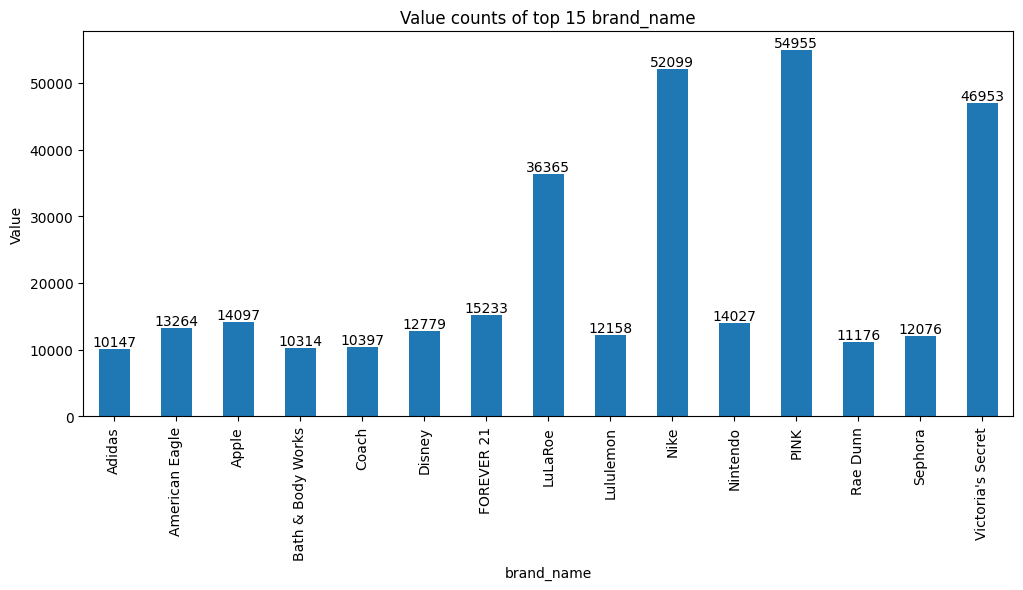

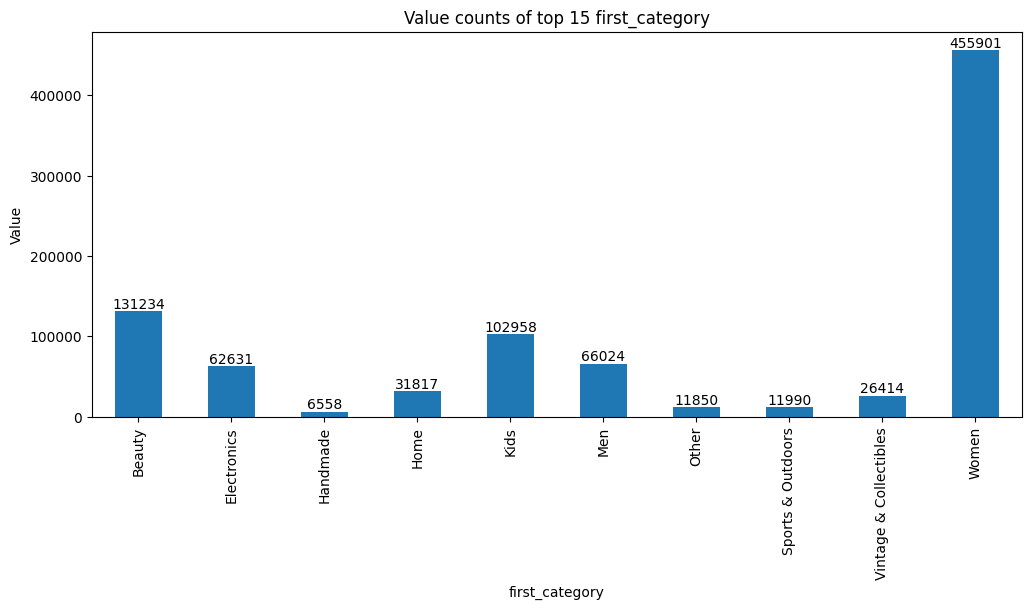

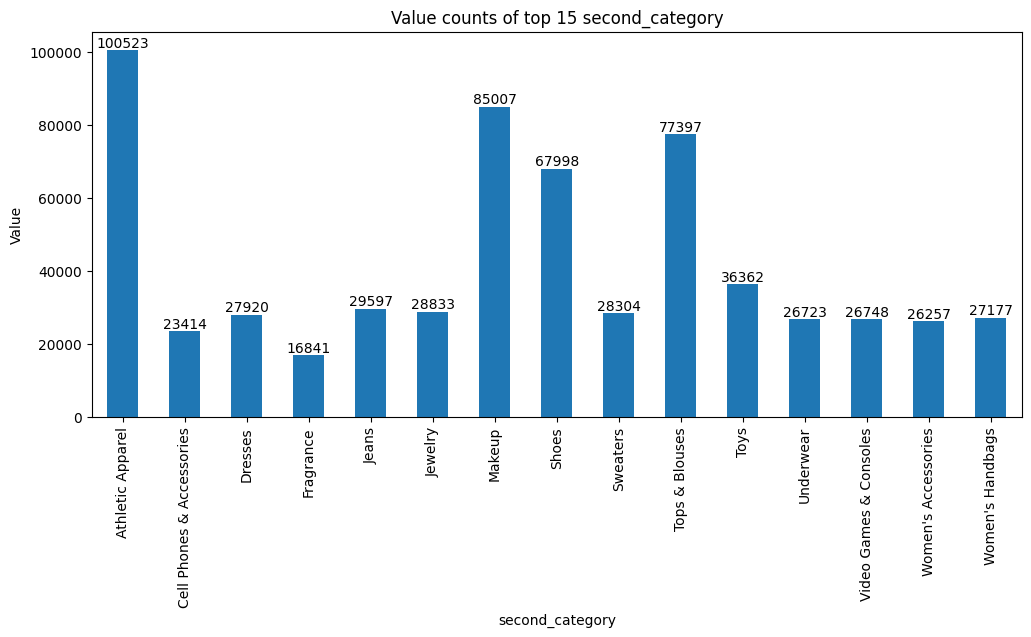

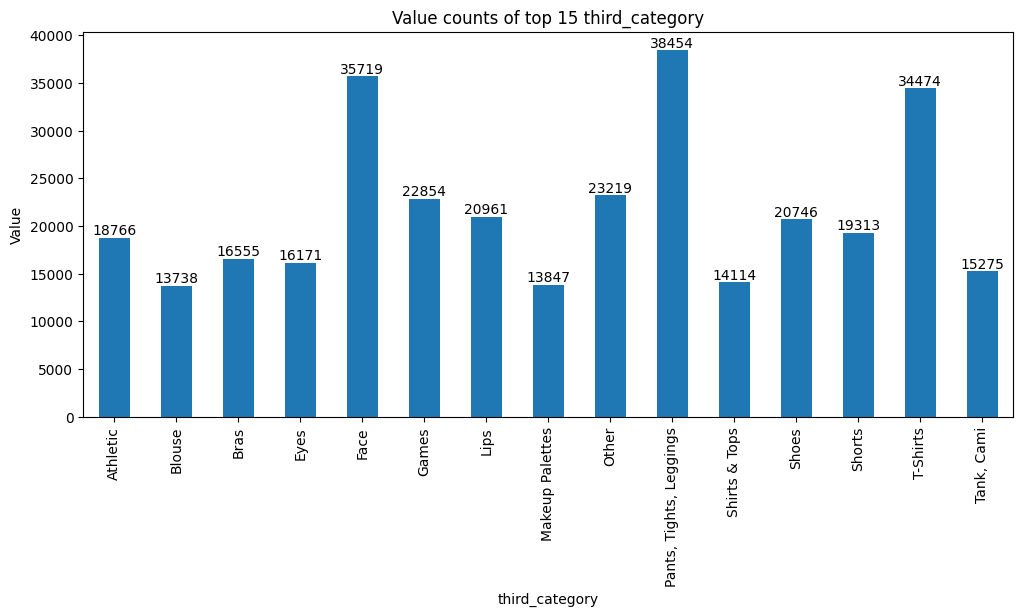

In [59]:
for i in ['brand_name', 'first_category', 'second_category', 'third_category']:
  plt.figure(figsize=(12, 5))
  df_copy = data[data[i].isin(data[i].value_counts().head(15).index)]
  ax = df_copy.groupby(i).size().plot(kind='bar')

  for container in ax.containers:
    ax.bar_label(container, label_type='edge')

  plt.title(f'Value counts of top 15 {i}')
  plt.xlabel(f'{i}')
  plt.ylabel('Value')
  plt.show()

# **IMBALANCED DATA DETECTION AND TREATMENT**

***Label encoding cho các columns***

In [ ]:
data = data.drop(columns = ['item_description'])

In [ ]:
obj_cols = data.select_dtypes(include=['object']).columns
for i in obj_cols:
  print(i, len(data[i].unique()))

brand_name 4737
first_category 10
second_category 113
third_category 800
price_in_description 2
descr_len 204


In [ ]:
#Label encoding
for i in obj_cols:
  frequency = data[i].value_counts()
  sorted_values = frequency.index
  value_to_code = {value: code for code, value in enumerate(sorted_values)}
  data[i] = data[i].map(value_to_code)

***Sử dụng KNN để cân bằng lại dữ liệu***

In [ ]:
def oversampling_imbalanced_data(data, target_feature = 'shipping', k_neighbors = 5):
    if k_neighbors >= min(Counter(data[target_feature]).values()):
        return data
    X = data.drop(target_feature, axis=1)
    y = data[target_feature]
    oversampler = SMOTE(k_neighbors = k_neighbors)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns),
                              pd.DataFrame(y_resampled, columns=[target_feature])], axis=1)
    return data_resampled

In [ ]:
data_resampled = oversampling_imbalanced_data(data, target_feature = 'shipping', k_neighbors = 5)

In [ ]:
data_resampled = oversampling_imbalanced_data(data_resampled, target_feature = 'price_in_name', k_neighbors = 5)

***Scaler để cân bằng dữ liệu:***

In [ ]:
#Hàm xử lý các cột bị lệch bằng phép biến đổi logarit, đưa chúng về các giá trị ít lệch hơn
def transform_skewed_features(data_resampled, skewed_features):
  for col in skewed_features:
    data_resampled[col] = np.log1p(data_resampled[col])

#standard Scaler chuẩn hóa các cột có phân phối bình thường
def transform_non_skewed_features(data_resampled, non_skewed_features):
  standardScaler = StandardScaler()
  for col in non_skewed_features:
    data_resampled[col] = standardScaler.fit_transform(data_resampled[[col]])

In [ ]:
data_resampled['price'] = np.log1p(data_resampled['price'])

In [ ]:
corr = data_resampled.corr()
corr.style.background_gradient(cmap='coolwarm')

,train_id,item_condition_id,brand_name,price,first_category,price_in_description,descr_len,shipping,price_in_name
train_id,1.000000,0.016103,-0.023656,0.038295,-0.024627,0.019594,-0.025166,-0.024794,-0.018681
item_condition_id,0.016103,1.000000,0.001412,0.014241,-0.041137,-0.096900,-0.165682,-0.159203,-0.438056
brand_name,-0.023656,0.001412,1.000000,-0.072290,0.089127,0.002461,0.006926,0.004397,-0.011900
price,0.038295,0.014241,-0.072290,1.000000,-0.079746,0.040340,0.014225,-0.226199,-0.060978
first_category,-0.024627,-0.041137,0.089127,-0.079746,1.000000,0.008896,0.094997,0.038288,-0.020608
price_in_description,0.019594,-0.096900,0.002461,0.040340,0.008896,1.000000,0.198449,-0.076332,0.093120
descr_len,-0.025166,-0.165682,0.006926,0.014225,0.094997,0.198449,1.000000,0.010226,0.215355
shipping,-0.024794,-0.159203,0.004397,-0.226199,0.038288,-0.076332,0.010226,1.000000,-0.041938
price_in_name,-0.018681,-0.438056,-0.011900,-0.060978,-0.020608,0.093120,0.215355,-0.041938,1.000000


In [ ]:
#Xóa đi 2 columns không còn quan trọng nữa:
data_resampled = data_resampled.drop(columns = ['third_category', 'second_category'])

# **PREDICTION**

In [ ]:
#Hàm đánh giá hiệu suất
def print_scores(y_test, y_pred):
  print(mean_squared_error(y_test, y_pred))

In [ ]:
#Hàm chia tập train-test và MinMax Scaler
def preprocess_data(data_resampled, test_size=0.2, random_state=42):

    # Chia tập train-test
    X = data_resampled.drop(columns=['price'], axis=1)
    y = data_resampled['price']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data_resampled)

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    #'Random Forest': RandomForestRegressor(),
    #'Gradient Boosting': GradientBoostingRegressor(),
    #'AdaBoost': AdaBoostRegressor(),
    #'Extra Trees': ExtraTreesRegressor(),
    #'Support Vector Regression (SVR)': SVR(),
    #'Decision Tree': DecisionTreeRegressor(),
    'K-Neighbors': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor()
}

# Huấn luyện và đánh giá từng mô hình
results = {}
for name, model in models.items():
    # Huấn luyện mô hình
    model.fit(X_train, y_train)

    # Dự đoán trên tập kiểm tra
    y_pred = model.predict(X_test)

    # Đánh giá mô hình bằng Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse
    print(f'{name} - Mean Squared Error: {mse}')

# Hiển thị kết quả đánh giá của tất cả các mô hình
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Mean Squared Error'])
print("\nSummary of Model Performance:")
print(results_df)

Linear Regression - Mean Squared Error: 0.28674080712695865
Ridge Regression - Mean Squared Error: 0.2867408071561507
K-Neighbors - Mean Squared Error: 0.2037744369121732
XGBoost - Mean Squared Error: 0.2096611095509347
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.357328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 732
[LightGBM] [Info] Number of data points in the train set: 1687792, number of used features: 8
[LightGBM] [Info] Start training from score 2.888008
LightGBM - Mean Squared Error: 0.23858699828568158

Summary of Model Performance:
               Model  Mean Squared Error
0  Linear Regression            0.286741
1   Ridge Regression            0.286741
2        K-Neighbors            0.203774
3            XGBoost            0.209661
4           LightGBM            0.238587


In [ ]:
data_resampled['price'].describe()

,price
count,2.109740e+06
mean,2.888061e+00
std,5.565252e-01
min,0.000000e+00
25%,2.484907e+00
50%,2.880071e+00
75%,3.280632e+00
max,4.174387e+00


***Nhận xét: XGBOOST và KNN có thể cho kết quả tốt nhất***